[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_4.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_4.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_4.ipynb)

### based on Fig. 4 from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [5]:
import numpy as np
import os
from matplotlib import pyplot
from matplotlib import ticker
from open_atmos_jupyter_utils import show_plot

from PySDM.physics import si
from PySDM.products import (
    ParcelDisplacement, ActivatedMeanRadius, RadiusStandardDeviation
)
from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

In [6]:
products=(
    ParcelDisplacement(
        name='z'),
    ActivatedMeanRadius(
        name='r_act',count_activated=True, count_unactivated=False),
    RadiusStandardDeviation(
        name="radius_std", count_activated=True, count_unactivated=False),
)
vertical_velocity=("0.25","1","4")
output = { velocity:
    {
    case: Simulation(Settings(
        vertical_velocity=float(velocity),
        dt=1*si.s if 'CI' not in os.environ else 50 * si.s,
        n_sd=200 if 'CI' not in os.environ else 10,
        aerosol=case
    ), products=products).run()
    for case in ("pristine", "polluted")
    }
    for velocity in vertical_velocity
}
legend=[velocity+' m/s' for velocity in vertical_velocity]

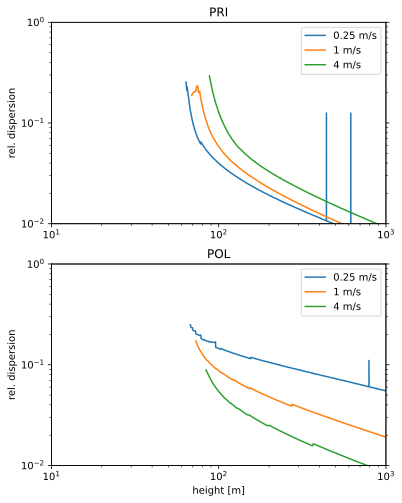

HTML(value="<a href='./fig4.pdf' target='_blank'>./fig4.pdf</a><br>")

In [4]:
fig, axs = pyplot.subplots(2, 1, figsize=(6, 8))
np.seterr(invalid="ignore")
for axis, aerosol in ((axs[0],"pristine"),(axs[1],"polluted")):
    for w in vertical_velocity:
        r=np.array(output[w][aerosol]['products']['r_act'])
        d=np.array(output[w][aerosol]['products']['radius_std'])
        axis.plot(np.array(output[w]["polluted"]['products']['z']),np.where(r*10**6>2,np.divide(d,r),np.nan))

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(0.01,1)
    ax.set_xlim(10,1000)
    ax.set_ylabel('rel. dispersion')
    ax.legend(legend)
axs[1].set_xlabel('height [m]')
axs[0].set_title('PRI')
axs[1].set_title('POL')

ax0, ax1 = [axs[0].twinx(), axs[1].twinx()]
for ax in [ax0,ax1]:
    ax.set_yscale('log')
    ax.set_ylim(0.01,1)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
show_plot("fig4.pdf")